In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing as pp
from pyod.models.iforest import IForest
from imblearn.over_sampling import SMOTE

from sklearn import linear_model as lm 
from sklearn import svm 
from sklearn import neighbors as knn

import sklearn.metrics as m
import sklearn.base as b
import optuna
import joblib 

import time
import serial 
from IPython.display import clear_output
import os
import warnings

plt.style.use('bmh')
warnings.filterwarnings('ignore')

RS = 8 #random_state

c:\Users\honor\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# IO utils


In [2]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

    Parameters:
    ---ы
        path_palm_data  (str): path to csv data file
        n_omg_channels  (int): Number of OMG channels
        n_acc_channels  (int): Number of Accelerometer channels,      default = 0
        n_gyr_channels  (int): Number of Gyroscope channels,          default = 0
        n_mag_channels  (int): Number of Magnetometer channels,       default = 0
        n_enc_channels  (int): Number of Encoder channels,            default = 0
        button_ch      (bool): If button channel is present,          default = True
        sync_ch        (bool): If synchronization channel is present, default = True
        timestamp_ch   (bool): If timestamp channel is present,       default = True

    Returns:
    ---
        df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Data

**Abbreviations**
* OMG — optomiography  
* ACC — accelerometer  
* GYR — gyroscope  
* ENC — encoders (fingers of prosthesis or gloves)  
* model — model of data  

**X features**
* '0', ..., '49' - каналы OMG датчиков
* 'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
* 'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
* 'BUTTON' - не используется
* 'SYNC' - синхронизация данных с протоколом
* 'ts' - метка времени

In [3]:
datas = []

for dirname, _, filenames in os.walk('.\data'):
    for filename in filenames:
        datas.append(os.path.join(dirname, filename))

datas = list(filter(lambda x: True if 'protocol' not in x else False, datas))


data_names = []

for path in datas:    
    d_path = path.split('\\')[-1]
    
    data_names.append(d_path)

data_names.remove('meta_information.csv')


data_names

['2023-04-18_19-08-47 gestures train.palm',
 '2023-05-05_17-57-30.palm',
 '2023-05-07_15-19-05.palm',
 '2023-05-07_16-54-27.palm',
 '2023-05-12_19-17-00.palm',
 '2023-05-15_16-16-08.palm',
 '2023-05-15_17-12-24.palm',
 '2023-05-19_12-04-02.palm',
 '2023-05-22_17-04-29.palm',
 '2023-05-22_20-22-01.palm',
 '2023-05-31_15-46-37.palm',
 '2023-05-31_17-14-41.palm',
 '2023-06-05_16-12-38.palm',
 '2023-06-05_17-53-01.palm',
 '2023-06-20_12-34-17.palm',
 '2023-06-20_13-30-15.palm',
 '2023-06-20_14-43-11.palm',
 '2023-09-12_12-55-22.palm',
 '2023-09-12_14-59-23.palm',
 '2023-09-13_22-14-05.palm',
 '2023-09-29_09-20-47.palm',
 '2023-09-29_11-03-50.palm',
 '2023-09-30_08-06-44.palm',
 '2023-10-18_08-05-29.palm',
 '2023-10-18_11-16-21.palm',
 '2023-10-23_10-11-45.palm',
 '2023-10-23_14-07-13.palm',
 '2023-10-23_16-23-02.palm',
 '2023-10-25_08-52-30.palm',
 '2023-10-25_11-08-46.palm',
 'patched_2023-10-25_09-44-02.palm']

In [4]:
palm_file = './data/' + data_names[0]
gestures = read_omg_csv(palm_file, 
                        n_omg_channels=50,
                        n_acc_channels=3, 
                        n_gyr_channels=3, 
                        n_enc_channels=6, 
                        n_mag_channels=0)

gestures

0  1   2     3     4     5     6   7   8   9  ...  GYR2  ENC0  ENC1  \
0      10  8  28  2846  2931  2873  2597  24   8  13  ...    31     0     0   
1      16  8  29  2847  2930  2875  2598  24   8   6  ...    31     0     0   
2      10  8  29  2847  2930  2875  2598  25   8   5  ...    30     0     0   
3       0  8  29  2845  2927  2870  2594  24   8   6  ...    30     0     0   
4       9  8  25  2851  2933  2877  2599  24   8   6  ...    28     0     0   
...    .. ..  ..   ...   ...   ...   ...  ..  ..  ..  ...   ...   ...   ...   
37603  10  5  17  2369  2498  2677  2425  20   8   5  ...    31     0     0   
37604  10  7  21  2400  2529  2697  2441  21  17   6  ...    30     0     0   
37605  10  6  21  2429  2557  2713  2454  19   7   5  ...    33     0     0   
37606   0  7  18  2446  2565  2720  2459  22   8   6  ...    31     0     0   
37607  10  6  18  2464  2597  2737  2472  20   8  13  ...    28     0     0   

       ENC2  ENC3  ENC4  ENC5  BUTTON  SYNC       ts  
0         0     0     0     0       0     0  1174989  
1         0     0     0     0       0     0  1175022  
2         0     0     0     0       0     0  1175055  
3         0     0     0     0       0     0  1175088  
4         0     0     0     0       0     0  1175121  
...     ...   ...   ...   ...     ...   ...      ...  
37603     0     0     0     0       0     0  2415888  
37604     0     0     0     0       0     0  2415921  
37605     0     0     0     0       0     0  2415954  
37606     0     0     0     0       0     0  2415987  
37607     0     0     0     0       0     0  2416020  

[37608 rows x 65 columns]

In [5]:
print(f"All columns:\n{gestures.columns}\n")

OMG_CH = [str(i) for i in range(50)]
ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

All columns:
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


In [6]:
gestures_omg_ch = gestures[OMG_CH]

gestures_omg_ch

0  1   2     3     4     5     6   7   8   9  ...  40  41  42  43  44  \
0      10  8  28  2846  2931  2873  2597  24   8  13  ...  32  28  10  11   8   
1      16  8  29  2847  2930  2875  2598  24   8   6  ...  33  31  10  12   8   
2      10  8  29  2847  2930  2875  2598  25   8   5  ...  11  30  11  12   8   
3       0  8  29  2845  2927  2870  2594  24   8   6  ...  33  32  10  12   0   
4       9  8  25  2851  2933  2877  2599  24   8   6  ...  32  29  10  11   6   
...    .. ..  ..   ...   ...   ...   ...  ..  ..  ..  ...  ..  ..  ..  ..  ..   
37603  10  5  17  2369  2498  2677  2425  20   8   5  ...  28  25  10  10   7   
37604  10  7  21  2400  2529  2697  2441  21  17   6  ...  30  24  10  10   7   
37605  10  6  21  2429  2557  2713  2454  19   7   5  ...  28  24  18   9   7   
37606   0  7  18  2446  2565  2720  2459  22   8   6  ...  12  26  11   8   7   
37607  10  6  18  2464  2597  2737  2472  20   8  13  ...  28  31   9   9   6   

       45  46  47  48  49  
0       5   8  13  32  25  
1       5   9  14  36  28  
2       7   8  14  36  28  
3       6  10  14  36  28  
4       5   9  13  33  33  
...    ..  ..  ..  ..  ..  
37603   6   9  13  34  24  
37604   5   8  11  35  25  
37605   5   9  13  33  25  
37606   6   9  15  36  27  
37607   5   7  13  32  24  

[37608 rows x 50 columns]

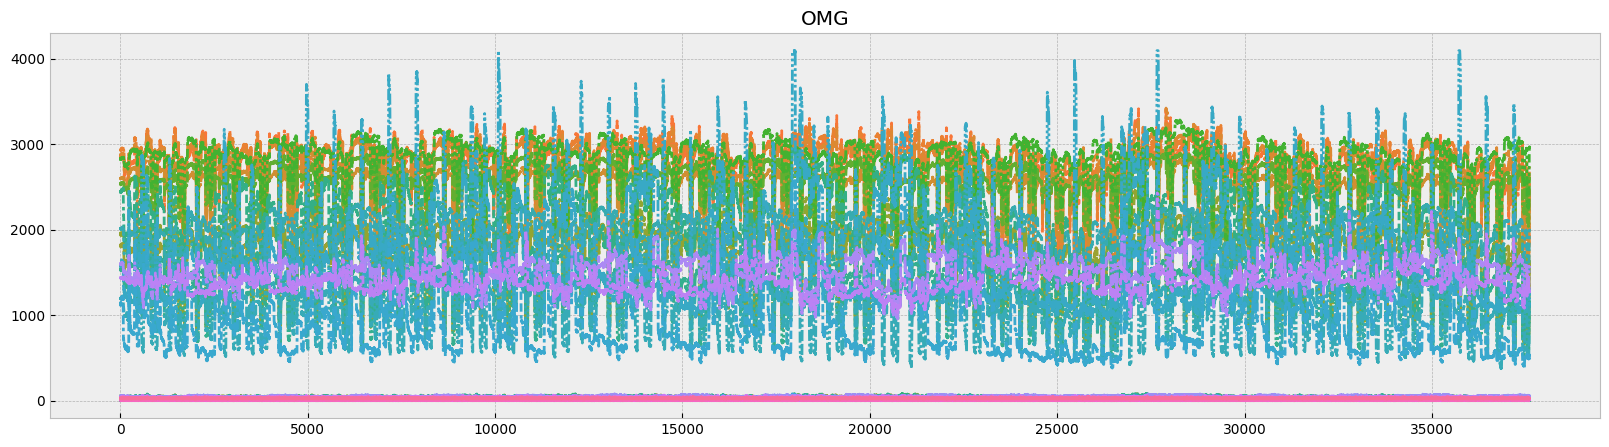

In [7]:
plt.figure(figsize=(20, 5))
sns.lineplot(gestures_omg_ch, legend=False)

plt.title('OMG')
plt.show()

# Protocol

In [8]:
gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)

gestures_protocol

Thumb  Index  Middle  Ring  Pinky  Thumb_stretch  Index_stretch  \
epoch                                                                    
0        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
1        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
2        1.0    0.0     0.0   0.0    0.0            0.0            0.0   
3        1.0    1.0     1.0   1.0    1.0            0.0            0.0   
4        0.0    0.0     0.0   0.0    0.0            1.0            1.0   
...      ...    ...     ...   ...    ...            ...            ...   
302      1.0    0.0     0.0   0.0    0.0            0.0            0.0   
303      1.0    1.0     1.0   1.0    1.0            0.0            0.0   
304      0.0    0.0     0.0   0.0    0.0            1.0            1.0   
305      1.0    1.0     0.0   0.0    0.0            0.0            0.0   
306      0.0    0.0     1.0   1.0    1.0            0.0            0.0   

       Middle_stretch  Ring_stretch  Pinky_stretch  Pronation  
epoch                                                          
0                 0.0           0.0            0.0        0.0  
1                 0.0           0.0            0.0        0.0  
2                 0.0           0.0            0.0        0.0  
3                 0.0           0.0            0.0        0.0  
4                 1.0           1.0            1.0        0.0  
...               ...           ...            ...        ...  
302               0.0           0.0            0.0        1.0  
303               0.0           0.0            0.0        1.0  
304               1.0           1.0            1.0        1.0  
305               0.0           0.0            0.0        1.0  
306               0.0           0.0            0.0        1.0  

[307 rows x 11 columns]

In [9]:
le = pp.LabelEncoder()

# FIT & TRANSFORM
gestures_protocol['gesture'] = le.fit_transform(
    gestures_protocol[[
        "Thumb", "Index", "Middle", "Ring", "Pinky",
        'Thumb_stretch', 'Index_stretch', 'Middle_stretch', 'Ring_stretch', 'Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

display(np.c_[le.transform(le.classes_), le.classes_])

gestures_protocol['gesture']

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

epoch
0      0
1      0
2      3
3      5
4      1
      ..
302    3
303    5
304    1
305    4
306    2
Name: gesture, Length: 307, dtype: int32

In [10]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
NUM_G = len(GESTURES)

GESTURES, NUM_G

(['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab'], 6)

In [11]:
def read_protocol_csv(palm_file, gestures):
    gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
    
    le = pp.LabelEncoder()

    gestures_protocol['gesture'] = le.fit_transform(
        gestures_protocol[[
            "Thumb", "Index", "Middle", "Ring", "Pinky",
            'Thumb_stretch', 'Index_stretch', 'Middle_stretch', 'Ring_stretch', 'Pinky_stretch'
        ]]
        .apply(lambda row: str(tuple(row)), axis=1)
    )
    
    y_cmd = pd.Series([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
    
    return y_cmd


y_cmd = read_protocol_csv(palm_file, gestures)

y_cmd

0        0
1        0
2        0
3        0
4        0
        ..
37603    0
37604    0
37605    0
37606    0
37607    0
Length: 37608, dtype: int32

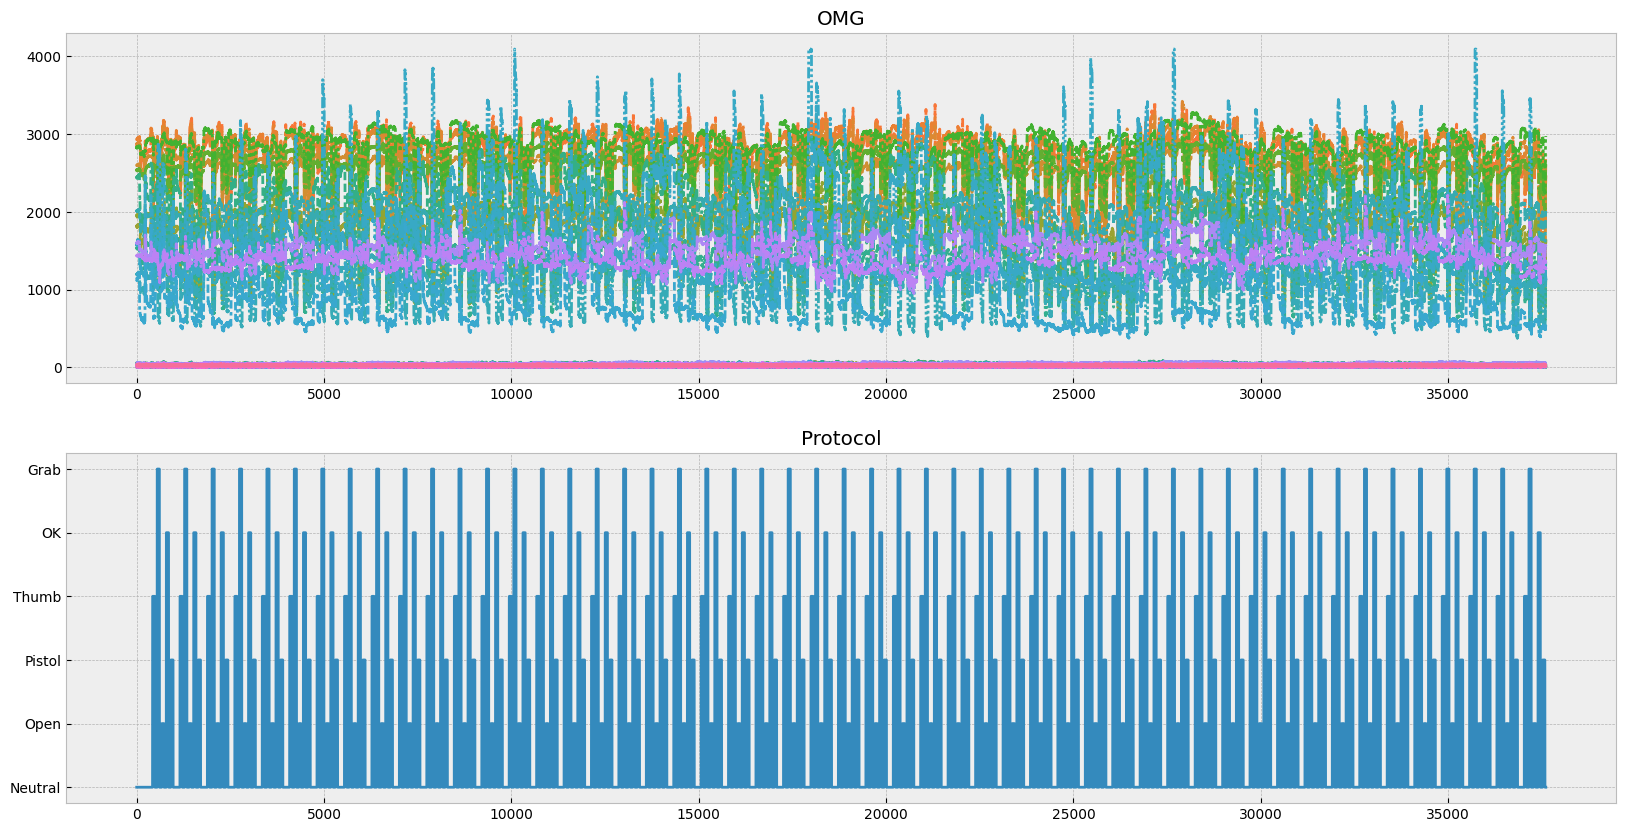

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(gestures_omg_ch, legend=False, ax=ax[0])
ax[0].set_title('OMG')

sns.lineplot(y_cmd, ax=ax[1])
ax[1].set_title('Protocol')
ax[1].set_yticks(range(NUM_G), GESTURES)

plt.show()

# Preprocessing & Modeling

In [13]:
binarise_y = lambda x: 1 if x != 0 else x 

def get_temp(data):
    scaler = pp.StandardScaler()
    data_scaled = scaler.fit_transform(data) 
    
    temp = pd.DataFrame(
        data_scaled,
        columns=data.columns
    ).abs() 
    
    return temp

### Shifting

Best shifting value: 16


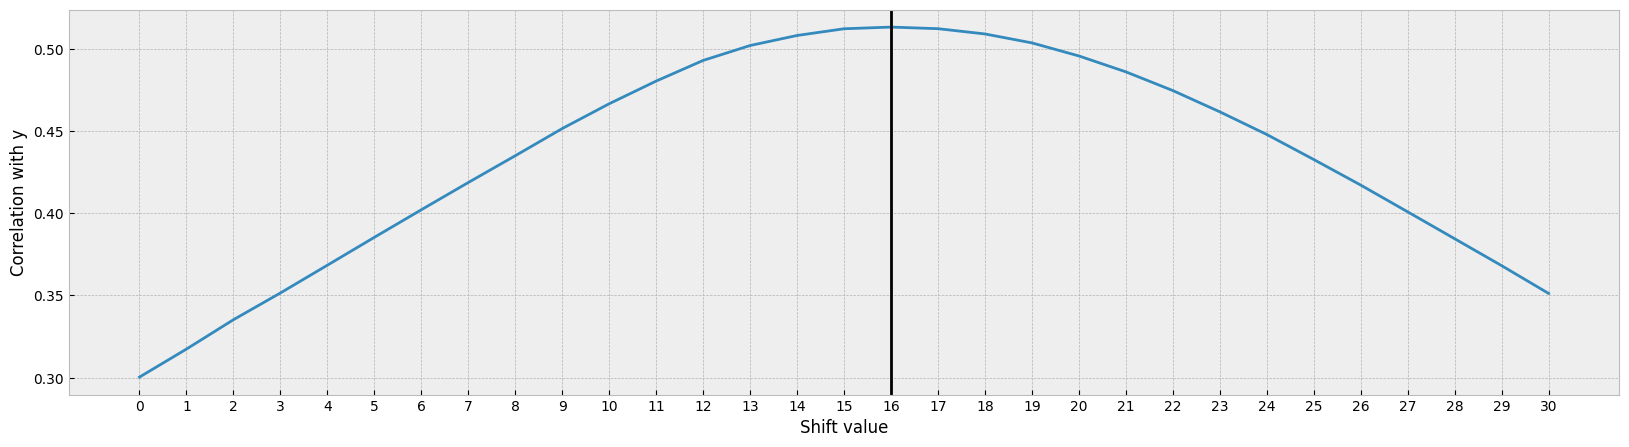

In [14]:
def select_shift(data, targ=y_cmd, plot=False):
    shift_corr = pd.Series() 
    
    disp = get_temp(data).sum(axis=1)
    t_bin = targ.apply(binarise_y)
    
    shift_range = range(31)
    for shift_value in shift_range:  
        shifted_y = (t_bin
                     .shift(shift_value)
                     .fillna(0))
        
        shift_corr.loc[shift_value] = disp.corr(shifted_y)
    
    best_shift = (shift_corr
                  .abs()
                  .sort_values(ascending=False)
                  .index[0])
    
    if plot:
        print('Best shifting value:', best_shift)
        
        plt.figure(figsize=(20, 5))
        sns.lineplot(shift_corr)

        plt.xticks(shift_range)
        plt.axvline(best_shift, color='black')
        
        plt.xlabel('Shift value')
        plt.ylabel('Correlation with y')
        plt.show()
    
    return int(best_shift)


best_shift = select_shift(gestures_omg_ch, plot=True)

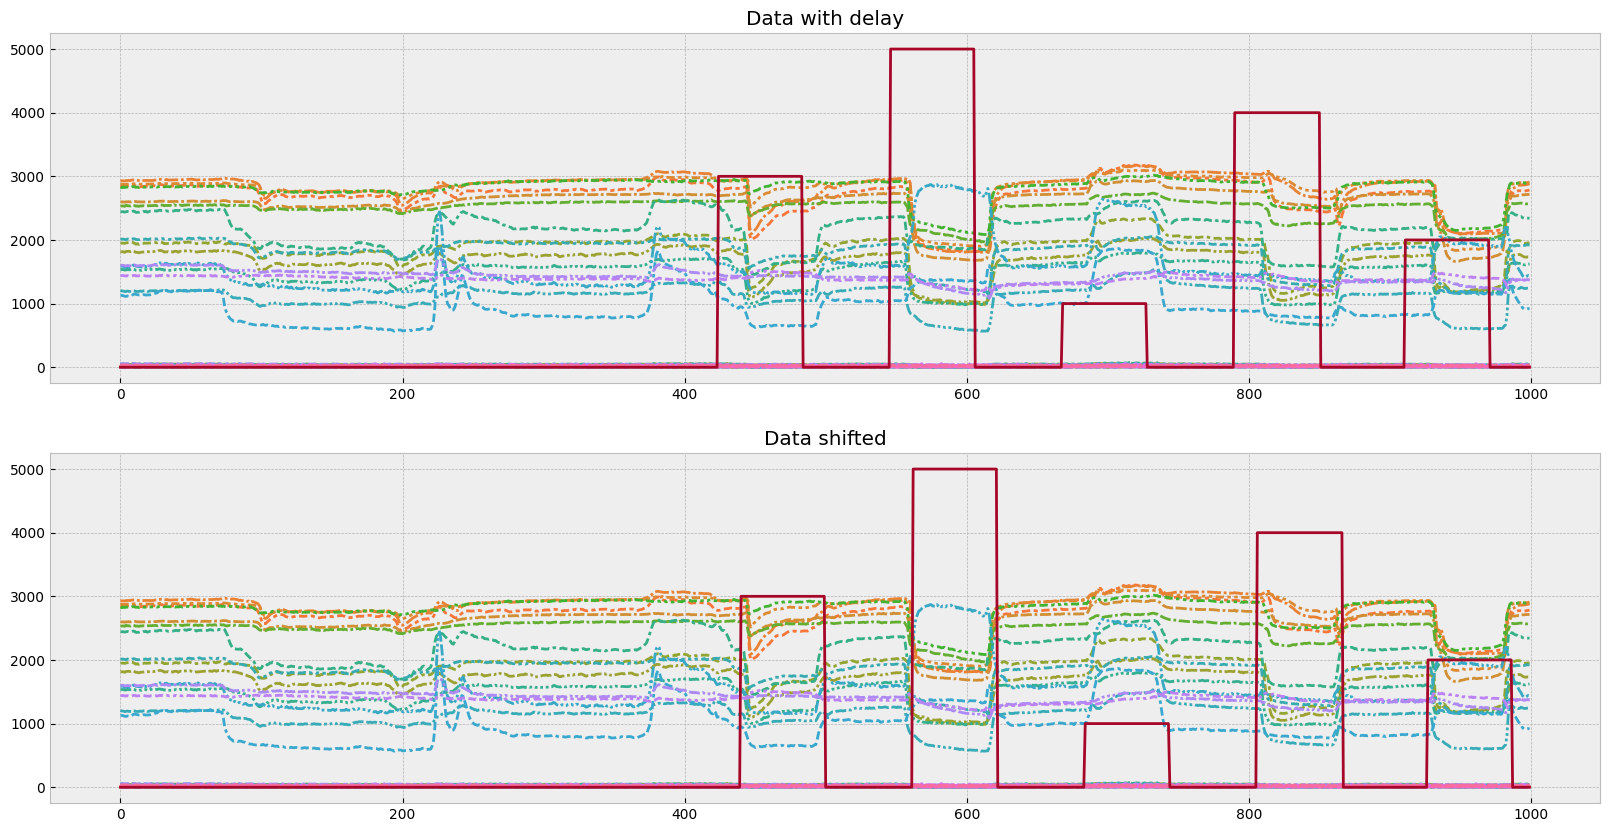

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(gestures_omg_ch.iloc[:1000], 
             legend=False, 
             ax=ax[0])
sns.lineplot(y_cmd.iloc[:1000]*1000, ax=ax[0])
ax[0].set_title('Data with delay')


shift_targ = lambda targ, shift: targ.shift(shift).fillna(0)
y_shifted = shift_targ(y_cmd, best_shift)

sns.lineplot(gestures_omg_ch.iloc[:1000], 
             legend=False, 
             ax=ax[1])
sns.lineplot(y_shifted.iloc[:1000]*1000, ax=ax[1])
ax[1].set_title('Data shifted')


fig.show()

### Smoothing

Best window value: 4


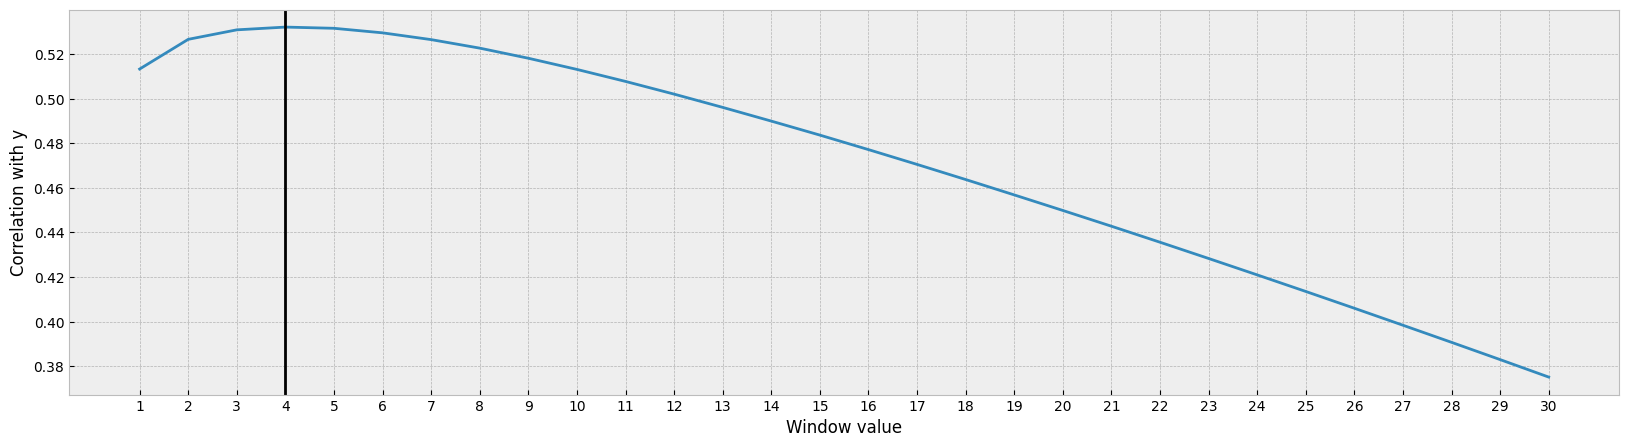

In [16]:
def select_window(data, targ=y_shifted, plot=False):
    smooth_corr = pd.Series()
    
    t_bin = targ.apply(binarise_y)
    temp = get_temp(data) 

    win_range = range(1, 31)
    for win_value in win_range:      
        smoothed_temp = (temp
                         .rolling(win_value, 1)
                         .mean())
        smoothed_disp = smoothed_temp.sum(axis=1)
        
        smooth_corr.loc[win_value] = smoothed_disp.corr(t_bin)
        
    best_win = smooth_corr.sort_values(ascending=False).index[0]
    
    if plot:
        print('Best window value:', best_win)
        
        plt.figure(figsize=(20, 5))
        sns.lineplot(smooth_corr)
        
        plt.xticks(win_range)
        plt.axvline(best_win, color='black')
        
        plt.xlabel('Window value')
        plt.ylabel('Correlation with y')
        plt.show()
    
    return int(best_win)


best_win = select_window(gestures_omg_ch, plot=True)

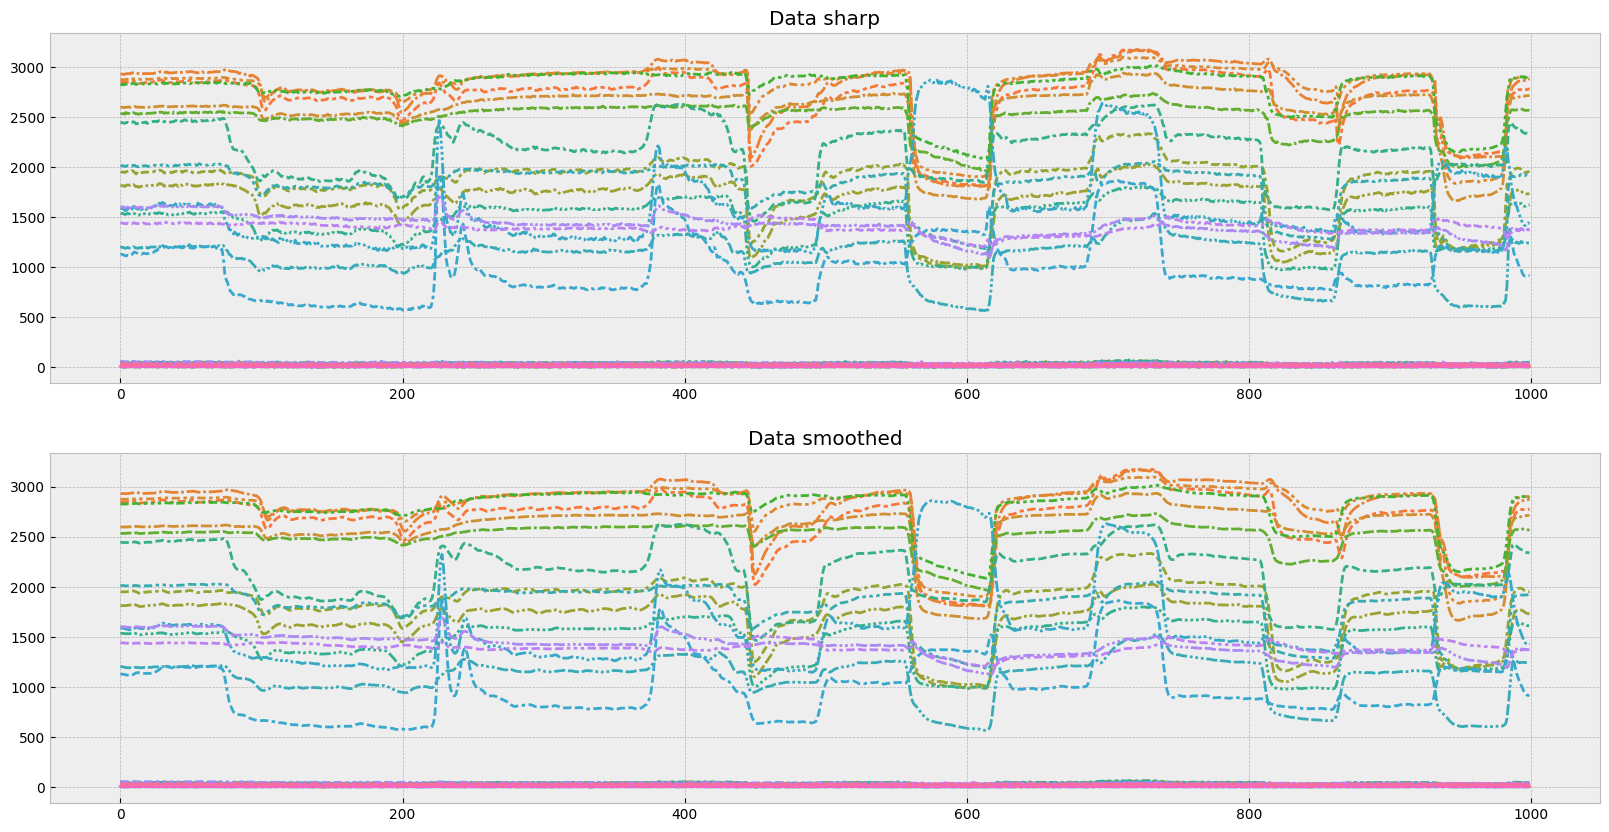

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(gestures_omg_ch.iloc[:1000], 
             legend=False, 
             ax=ax[0])
ax[0].set_title('Data sharp')


smoothe_data = lambda X, win: X.rolling(win, 1).mean()
gestures_smoothed = smoothe_data(gestures_omg_ch, best_win)

sns.lineplot(gestures_smoothed.iloc[:1000], 
             legend=False, 
             ax=ax[1])
ax[1].set_title('Data smoothed')


fig.show()

### Train-test split

In [18]:
df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)

df_meta.head()

montage  pilote_id  last_train_idx  len(train)  len(test)
0  2023-05-15_16-16-08.palm          1           23337       23337       5810
1  2023-05-15_17-12-24.palm          1           23336       23336       5803
2  2023-06-05_16-12-38.palm          1           17939       17939       4431
3  2023-06-05_17-53-01.palm          1           17771       17771       4435
4  2023-06-20_14-43-11.palm          1           17936       17936       4441

(29548, 50) (29548,)
(8060, 50) (8060,)


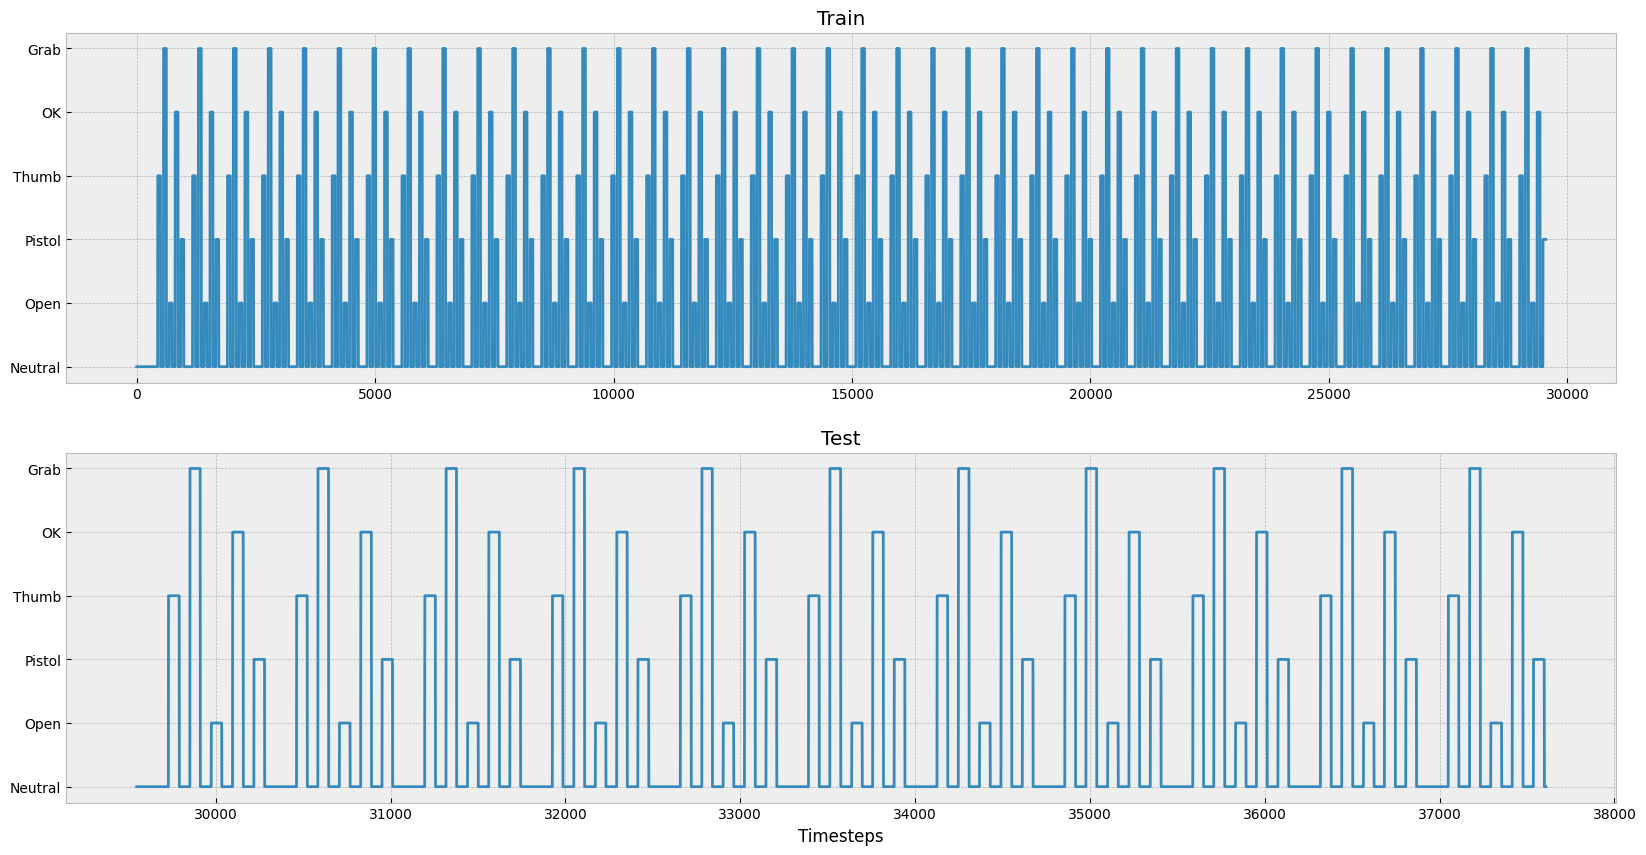

In [19]:
def train_test_split(palm_file, X, y, shift):
    palm_mask = df_meta['montage'] == palm_file.split('/')[-1]
    
    last_train_idx = df_meta[palm_mask]['last_train_idx'].values[0]+shift
    pilote_id = df_meta[palm_mask]['pilote_id'].values[0]
    
    X_train = X.iloc[:last_train_idx]
    y_train = y.iloc[:last_train_idx]

    X_test = X.iloc[last_train_idx:]
    y_test = y.iloc[last_train_idx:]
    
    return (X_train, X_test, 
            y_train, y_test, 
            last_train_idx, pilote_id) 


X_train, X_test, y_train, y_test = train_test_split(
    palm_file, 
    gestures_smoothed, 
    y_shifted, 
    best_shift
)[:4]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(y_train, ax=ax[0])
sns.lineplot(y_test, ax=ax[1])

ax[0].set_yticks(range(len(GESTURES)), GESTURES)
ax[0].set_title('Train')

ax[1].set_xlabel('Timesteps')
ax[1].set_yticks(range(len(GESTURES)), GESTURES)
ax[1].set_title('Test')

fig.show()

### Scaling

In [20]:
scaler = pp.StandardScaler()


def scale_data(X_train, X_test, scaler=scaler):
    COLS = X_train.columns
    
    scaler.fit(X_train)

    X_train_scaled = pd.DataFrame(
        scaler.transform(X_train), 
        columns=COLS
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=COLS
    )
    
    return X_train_scaled, X_test_scaled

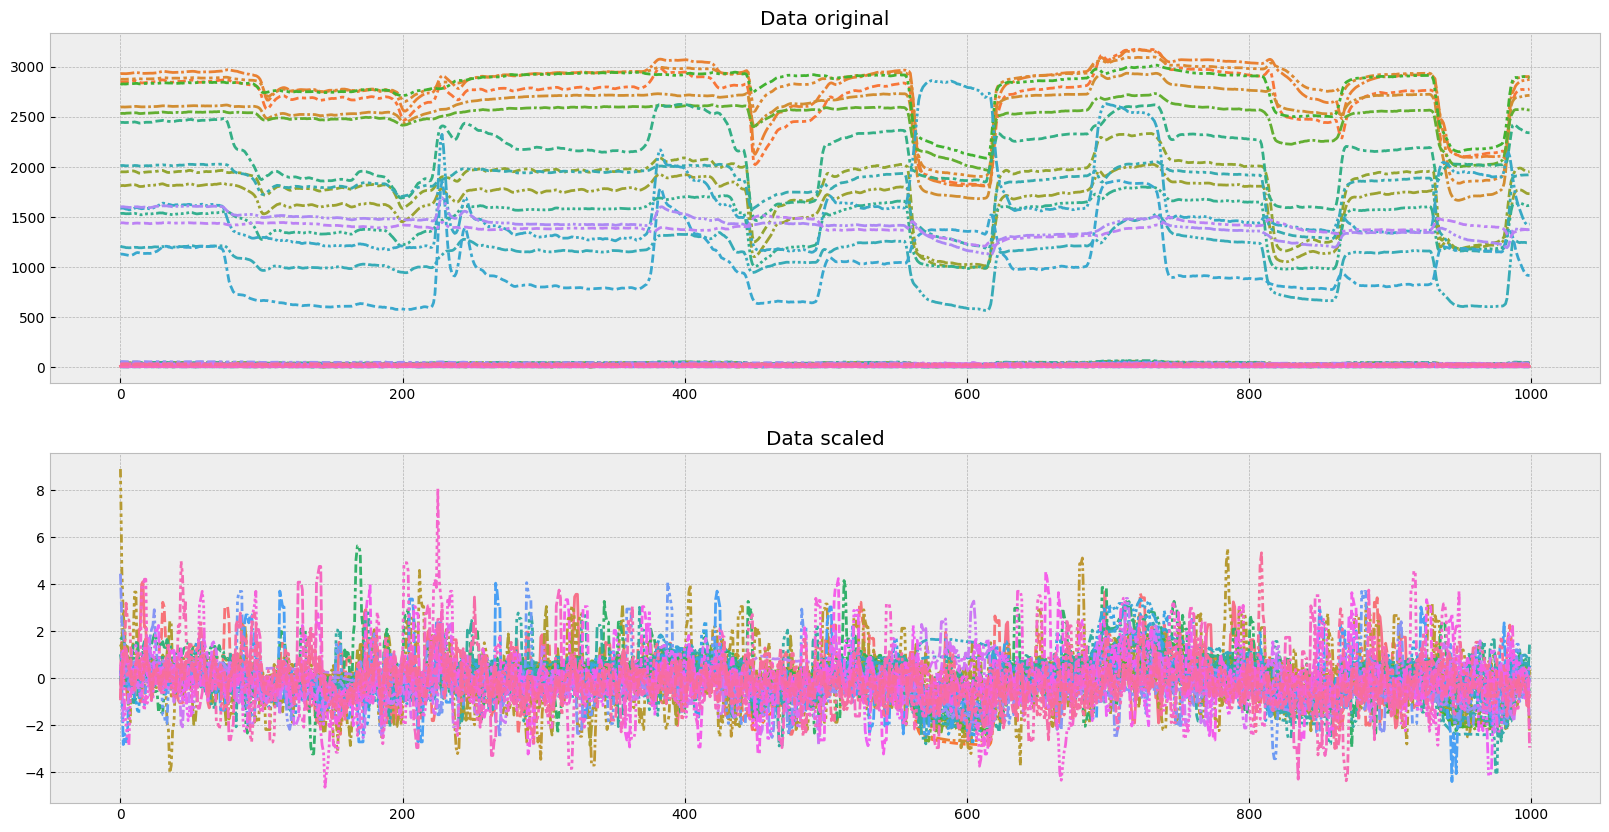

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(X_train.iloc[:1000], 
             legend=False, 
             ax=ax[0])
ax[0].set_title('Data original')


X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

sns.lineplot(X_train_scaled.iloc[:1000], 
             legend=False, 
             ax=ax[1])
ax[1].set_title('Data scaled')


fig.show() 

### Model selection

Session with Logistic Regression is done.
Session with Stochastic Gradient Descend is done.
Session with Support Vector Machine is done.
Session with K-Neighbors is done.
Session with Passive Aggressive is done.


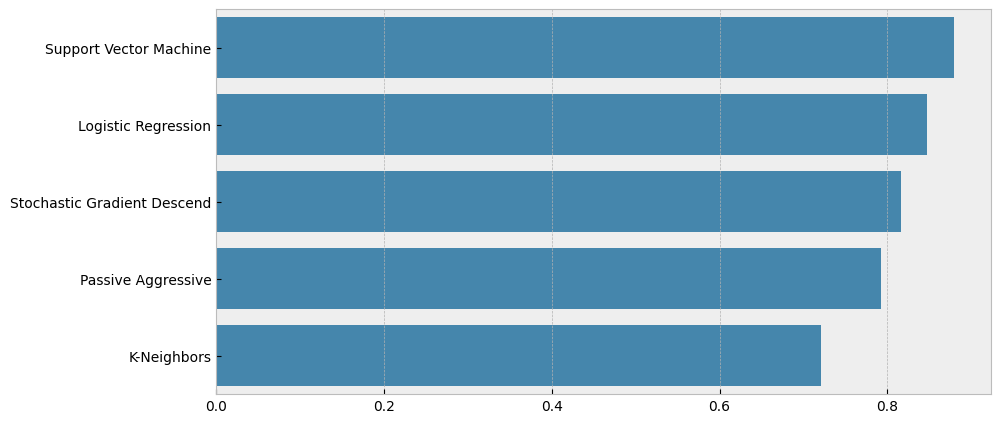

In [22]:
models = {
    'Logistic Regression': lm.LogisticRegression(random_state=RS), 
    'Stochastic Gradient Descend': lm.SGDClassifier(random_state=RS), 
    'Support Vector Machine': svm.SVC(random_state=RS), 
    'K-Neighbors': knn.KNeighborsClassifier(), 
    'Passive Aggressive': lm.PassiveAggressiveClassifier(random_state=RS)
}


model_scores = pd.Series()

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    model_scores.loc[name] = m.f1_score(y_test, y_pred, average='macro')
    print(f'Session with {name} is done.')


plt.figure(figsize=(10, 5))
sns.barplot(model_scores.sort_values(ascending=False), orient='h')

plt.show()

### Feature selection

Session with 50 features is done.
Session with 49 features is done.
Session with 48 features is done.
Session with 47 features is done.
Session with 46 features is done.
Session with 45 features is done.
Session with 44 features is done.
Session with 43 features is done.
Session with 42 features is done.
Session with 41 features is done.
Session with 40 features is done.
Session with 39 features is done.
Session with 38 features is done.
Session with 37 features is done.
Session with 36 features is done.
Session with 35 features is done.
Session with 34 features is done.
Session with 33 features is done.
Session with 32 features is done.
Session with 31 features is done.
Session with 30 features is done.
Session with 29 features is done.
Session with 28 features is done.
Session with 27 features is done.
Session with 26 features is done.
Session with 25 features is done.
Session with 24 features is done.
Session with 23 features is done.
Session with 22 features is done.
Session with 2

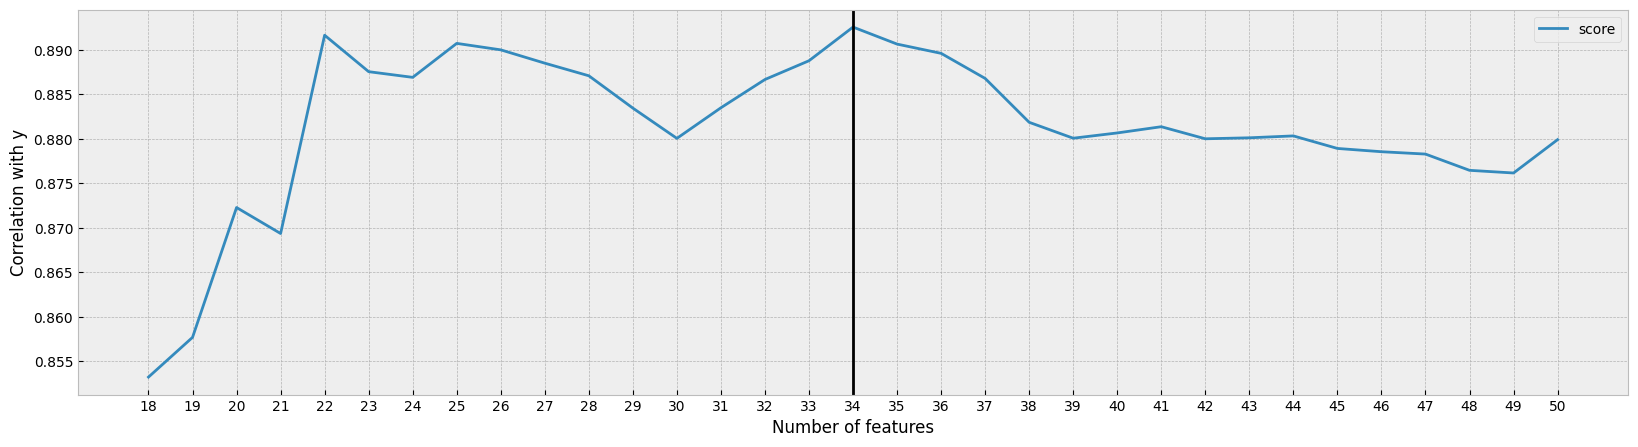

In [23]:
svm_model = svm.SVC(random_state=RS)


def select_features(data, targ=y_shifted, model=svm_model, plot=False):
    noise_corr = pd.Series()
    t_bin = targ.apply(binarise_y)

    for col in data.columns:    
        correlation = data[col].corr(t_bin)
        noise_corr.loc[col] = abs(correlation)

    noise_corr.sort_values(ascending=False, inplace=True)

    feature_scores = pd.DataFrame(columns=['features', 'score'])
    n_feats = noise_corr.shape[0]
    
    while n_feats > 0:
        features = noise_corr.iloc[:n_feats].index
        
        X_train_ = X_train_scaled.loc[:, features]
        X_test_ = X_test_scaled.loc[:, features]
        
        model.fit(X_train_, y_train)
        y_pred = model.predict(X_test_)
        
        score = m.f1_score(y_test, y_pred, average='macro')
        
        if score < 0.85:
            break
        else:
            feature_scores.loc[n_feats, 'features'] = features
            feature_scores.loc[n_feats, 'score'] = score
            
            print(f'Session with {n_feats} features is done.')
            n_feats -= 1
        
    best_features = (feature_scores
                     .sort_values('score', ascending=False)
                     .iloc[0, 0])
    
    if plot:
        print(f'\nBest {len(best_features)} features: \n{best_features}')
        
        plt.figure(figsize=(20, 5))
        sns.lineplot(feature_scores)
        
        plt.xticks(np.arange(n_feats, noise_corr.shape[0])+1)
        plt.axvline(len(best_features), color='black')
        
        plt.xlabel('Number of features')
        plt.ylabel('Correlation with y')
        plt.show()
    
    return list(best_features)


best_features = select_features(X_train_scaled, y_train, plot=True)

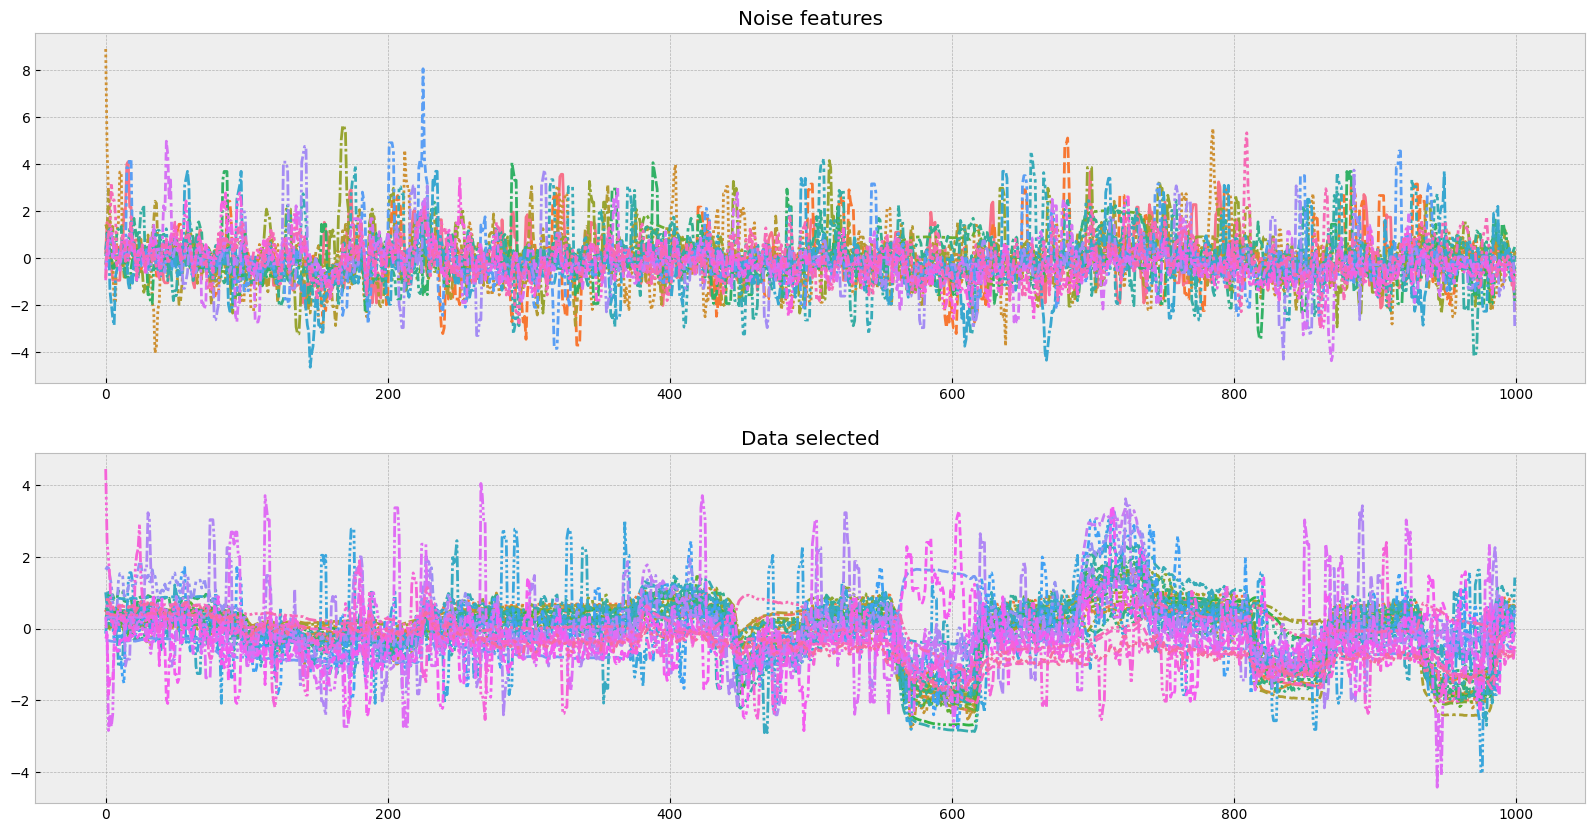

In [24]:
noisy_cols = X_train_scaled.drop(best_features, axis=1).columns


fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(X_train_scaled.iloc[:1000][noisy_cols], 
             legend=False, 
             ax=ax[0])
ax[0].set_title('Noise features')


X_train_selected = X_train_scaled[best_features]
X_test_selected = X_test_scaled[best_features]

sns.lineplot(X_train_selected.iloc[:1000], 
             legend=False, 
             ax=ax[1])
ax[1].set_title('Data selected')


fig.show()

### Metrics

In [25]:
def print_error(func):
    def func_w_error(*args, **kwargs):
        try:
            func(*args, **kwargs)
        except ValueError as ve:
            print(ve)
    
    return func_w_error


def get_f1(y, y_, sample):
    class_report = m.classification_report(
        y, y_, 
        target_names=GESTURES, 
        output_dict=True
    )
    
    scores_df = (
        pd.DataFrame(class_report)
        .loc['f1-score']
        .drop(['accuracy', 'weighted avg'], axis=0)
        .mul(100)
        .rename(sample)
    )
    
    return scores_df
    

@print_error
def model_report(model, Xy_set, fitted=False):
    # FIT & PREDICT
    X_train, X_test, y_train, y_test = Xy_set
    
    if not fitted:
        model.fit(X_train, y_train)
        
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # EVALUATE
    nunq = lambda a: len(np.unique(a))
    
    if ((nunq(y_pred_train) != NUM_G) or
        (nunq(y_pred_test) != NUM_G)):
        raise ValueError('Bad prediction')
    
    train_f1_gest = get_f1(y_train, y_pred_train, 'train')
    test_f1_gest = get_f1(y_test, y_pred_test, 'test')
    
    scores = pd.concat([train_f1_gest, test_f1_gest], axis=1)
    
    y_train_df = pd.DataFrame({'y_train': y_train, 'y_pred_train': y_pred_train})
    y_test_df = pd.DataFrame({'y_test': y_test, 'y_pred_test': y_pred_test})
    
    # VISUALISE
    fig, ax = plt.subplots(3, 1, figsize=(20, 15))

    sns.lineplot(scores, markers=True, ax=ax[0])
    ax[0].axhline(100, color='black')
    ax[0].axhline(90, color='black')
    ax[0].set_title('Scores')
    
    sns.lineplot(y_train_df, ax=ax[1])
    ax[1].set_yticks(range(NUM_G), GESTURES)
    ax[1].set_title('Train')

    sns.lineplot(y_test_df, ax=ax[2])
    ax[2].set_yticks(range(NUM_G), GESTURES)
    ax[2].set_title('Test')

    fig.show()   
    

def model_score(model, Xy_set, sample=('train', 'test'), fitted=True):    
    if sample == 'train':
        X, y = Xy_set[0], Xy_set[2]
    elif sample == 'test':
        X, y = Xy_set[1], Xy_set[3]
    else:
        raise ValueError('No such sample')
    
    if not fitted:
        model.fit(Xy_set[0], Xy_set[2])
    
    y_ = model.predict(X)
    score = m.f1_score(y, y_, average='macro') * 100
    
    return float(score) if len(set(y_)) == NUM_G else 0

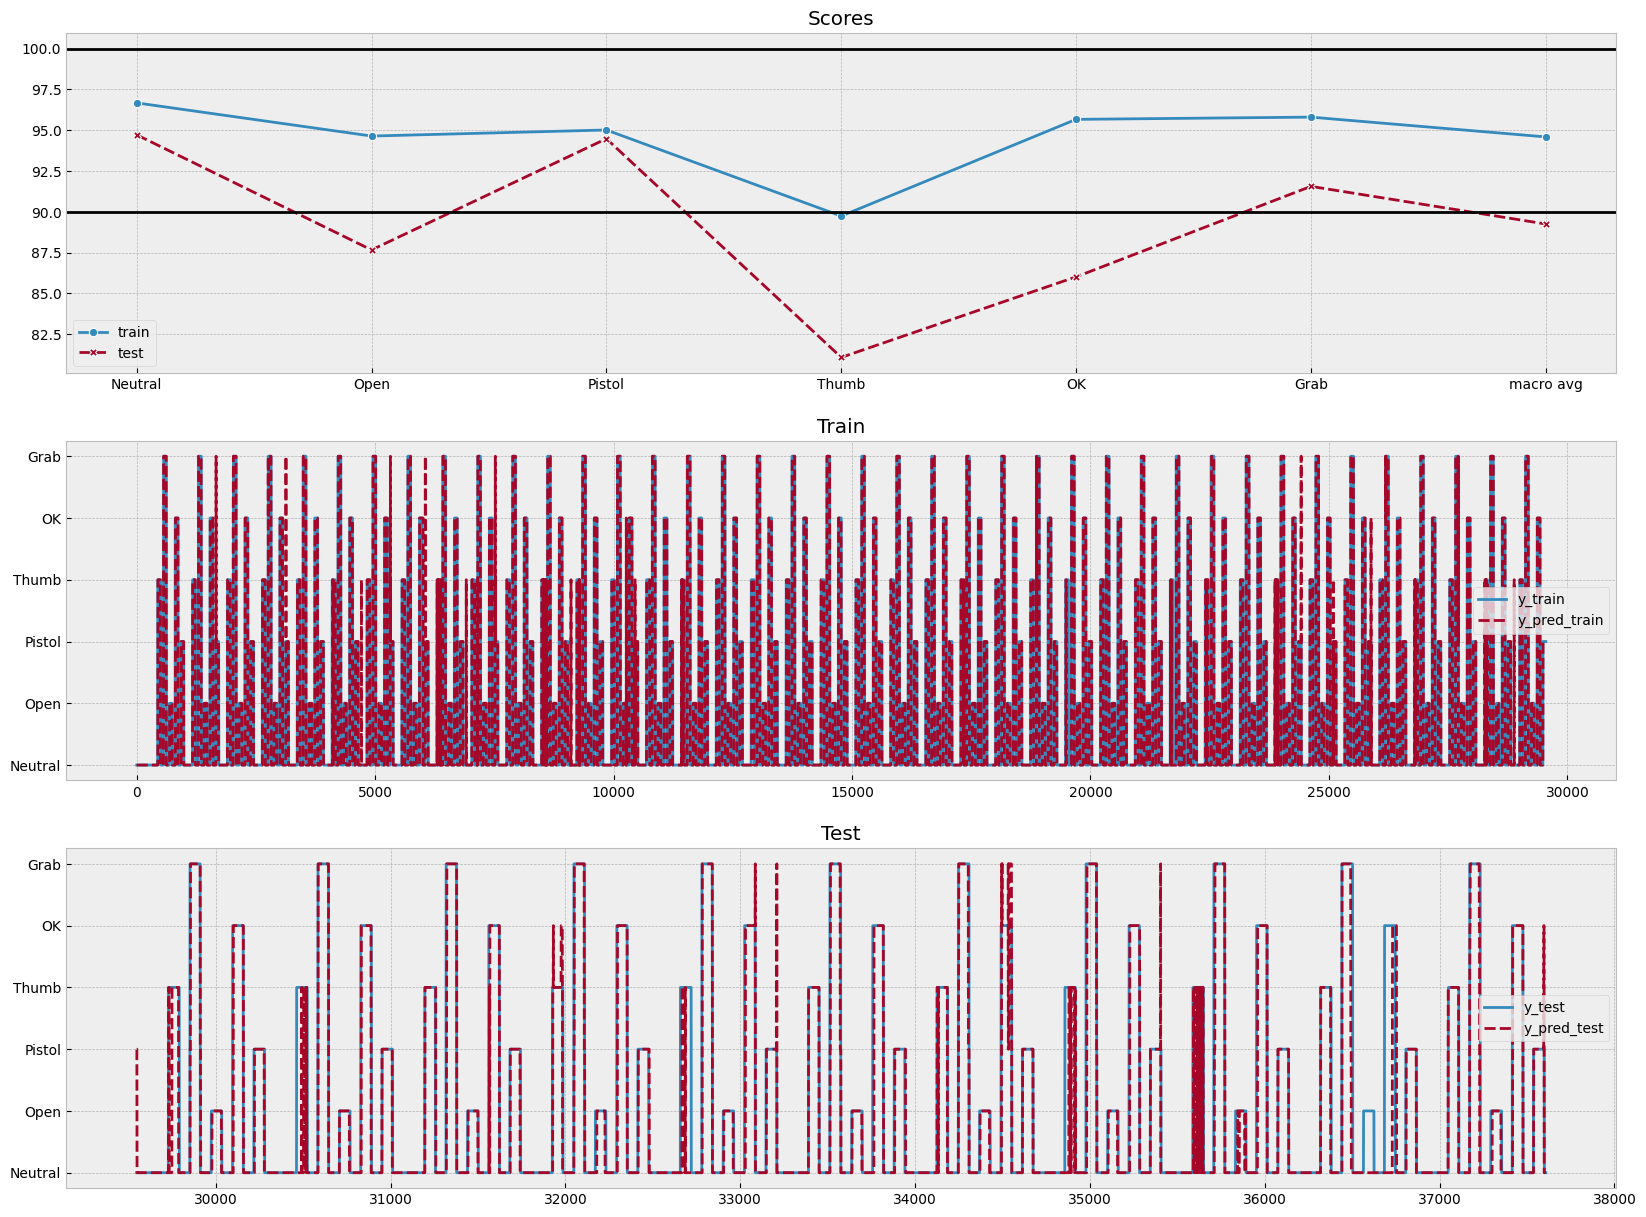

In [26]:
Xy_set = (X_train_selected, 
          X_test_selected, 
          y_train, 
          y_test)

model_report(svm_model, Xy_set)

In [27]:
BASELINE_SCORE = model_score(svm_model, Xy_set, 'test')

BASELINE_SCORE

89.25552863888609

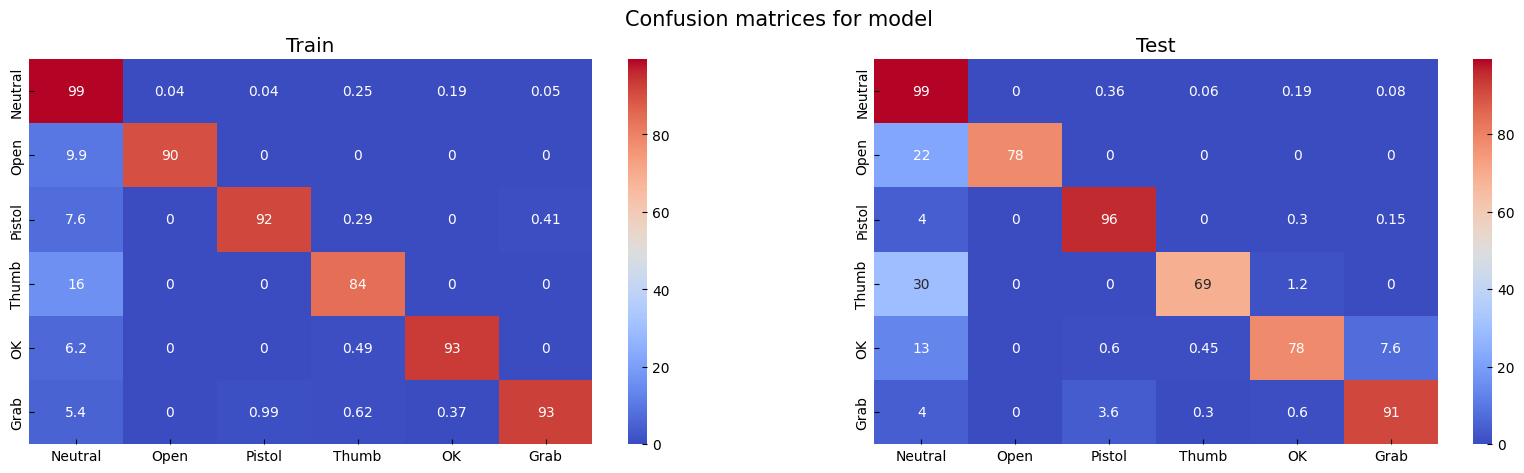

In [28]:
def show_confusion_matrix(model, Xy_set):
    X_train, X_test, y_train, y_test = Xy_set
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    cm_train = m.confusion_matrix(y_train, 
                                  y_pred_train, 
                                  normalize='true')*100
    cm_test = m.confusion_matrix(y_test, 
                                 y_pred_test, 
                                 normalize='true')*100
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    
    sns.heatmap(cm_train.round(2), 
                xticklabels=GESTURES, yticklabels=GESTURES,
                cmap='coolwarm', annot=True, ax=ax[0])
    ax[0].set_title('Train')
    
    sns.heatmap(cm_test.round(2), 
                xticklabels=GESTURES, yticklabels=GESTURES,
                cmap='coolwarm', annot=True, ax=ax[1])
    ax[1].set_title('Test')
    
    fig.suptitle('Confusion matrices for model', fontsize=15)
    fig.show()
    

show_confusion_matrix(svm_model, Xy_set)

### Class weights tuning

In [29]:
def opt_class_weights(trial: optuna.trial.Trial):
    weights = {
        0: trial.suggest_float(0, 1e-4, 10), 
        1: trial.suggest_float(1, 1e-4, 10), 
        2: trial.suggest_float(2, 1e-4, 10), 
        3: trial.suggest_float(3, 1e-4, 10), 
        4: trial.suggest_float(4, 1e-4, 10), 
        5: trial.suggest_float(5, 1e-4, 10)
    }
    
    model = (svm_model
             .set_params(class_weight=weights)
             .fit(X_train_selected, y_train))
    
    score = model_score(model, Xy_set, 'test')
    
    return score 


cw_study = optuna.create_study(
    study_name='Class weights for SVM', 
    direction='maximize'
)

cw_study.optimize(opt_class_weights, n_trials=100)

[I 2024-02-29 19:08:39,791] A new study created in memory with name: Class weights for SVM
[I 2024-02-29 19:08:46,952] Trial 0 finished with value: 89.34245203948144 and parameters: {0: 7.63974838048625, 1: 6.882691464417275, 2: 5.47430152209978, 3: 8.654101728379406, 4: 3.3437992709712243, 5: 0.6351392899376224}. Best is trial 0 with value: 89.34245203948144.
[I 2024-02-29 19:08:54,854] Trial 1 finished with value: 87.79170540009325 and parameters: {0: 6.74872529150877, 1: 3.784489760502775, 2: 0.7409849683232963, 3: 2.6467800178517478, 4: 9.723825393376682, 5: 5.013105034343352}. Best is trial 0 with value: 89.34245203948144.
[I 2024-02-29 19:09:02,186] Trial 2 finished with value: 87.53227641439665 and parameters: {0: 9.57872263223734, 1: 9.722914135521947, 2: 5.5315234467839005, 3: 3.7518682410595887, 4: 8.816032542418483, 5: 6.425343163397281}. Best is trial 0 with value: 89.34245203948144.
[I 2024-02-29 19:09:10,018] Trial 3 finished with value: 88.43080769380384 and parameters: 

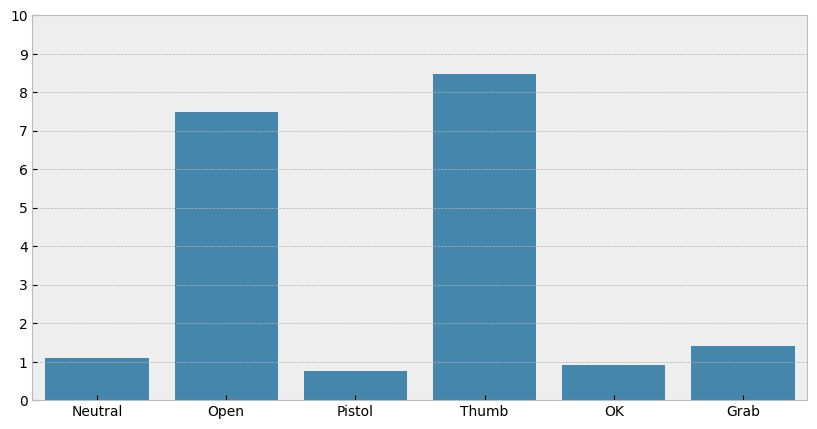

In [30]:
plt.figure(figsize=(10, 5))
sns.barplot(cw_study.best_params) 

plt.xticks(range(NUM_G), GESTURES)
plt.yticks(range(11))
plt.show()

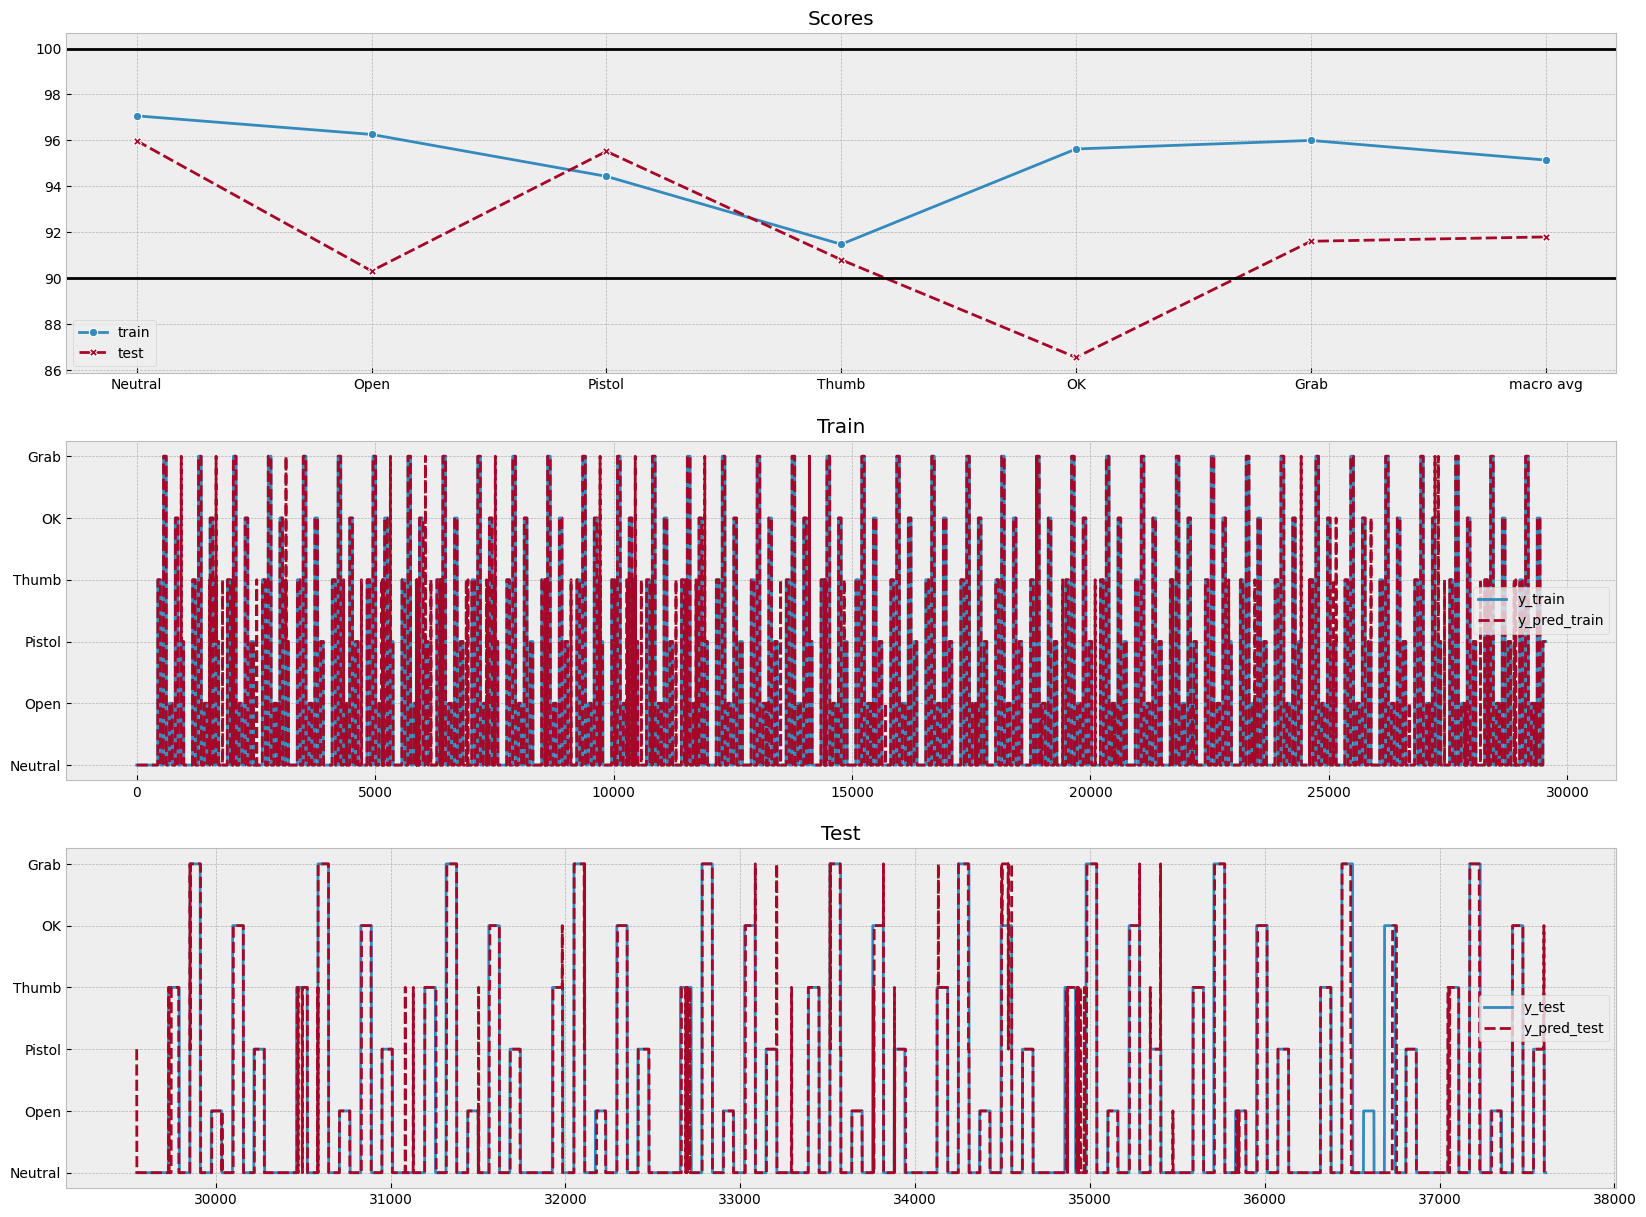

In [31]:
svm_model.set_params(class_weight = cw_study.best_params)

model_report(svm_model, Xy_set)

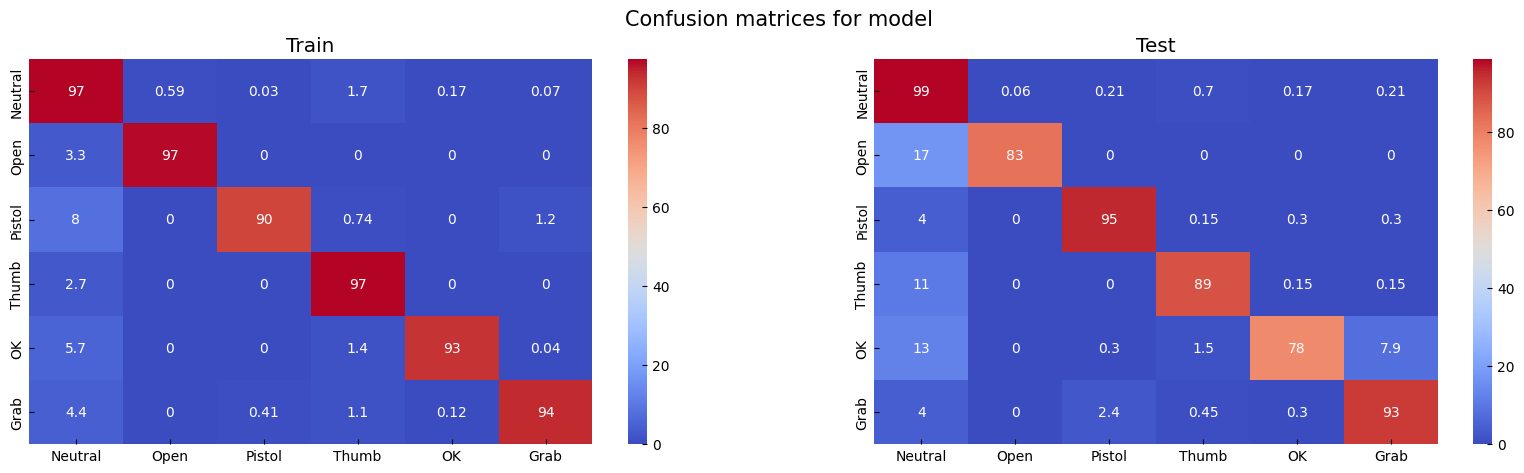

In [32]:
show_confusion_matrix(svm_model, Xy_set) 

### Optimisation, final etap

In [40]:
def opt_svm(trial):
    svm_model.set_params(
        C = trial.suggest_float('C', 1e-3, 5), 
        tol = trial.suggest_float('tol', 1e-7, 1),
    ).fit(X_train_selected, y_train)
    
    score = model_score(svm_model, Xy_set, 'test', True)
    
    return score


study_svm = optuna.create_study(study_name='SVM', direction='maximize')
study_svm.optimize(opt_svm, n_trials=100)

[I 2024-02-29 19:45:24,984] A new study created in memory with name: SVM
[I 2024-02-29 19:45:32,720] Trial 0 finished with value: 91.27036521550713 and parameters: {'C': 3.2571811791526604, 'tol': 0.8827906970582569}. Best is trial 0 with value: 91.27036521550713.
[I 2024-02-29 19:45:42,120] Trial 1 finished with value: 91.47707600570857 and parameters: {'C': 1.115935204794098, 'tol': 0.8993647715986498}. Best is trial 1 with value: 91.47707600570857.
[I 2024-02-29 19:45:52,073] Trial 2 finished with value: 91.69586529256831 and parameters: {'C': 1.2606659635946622, 'tol': 0.46680575002860786}. Best is trial 2 with value: 91.69586529256831.
[I 2024-02-29 19:46:00,514] Trial 3 finished with value: 90.81256665956846 and parameters: {'C': 4.917210970586091, 'tol': 0.28514656552823636}. Best is trial 2 with value: 91.69586529256831.
[I 2024-02-29 19:46:07,974] Trial 4 finished with value: 91.2111795623185 and parameters: {'C': 3.0504814154161064, 'tol': 0.8799167535990032}. Best is trial 2

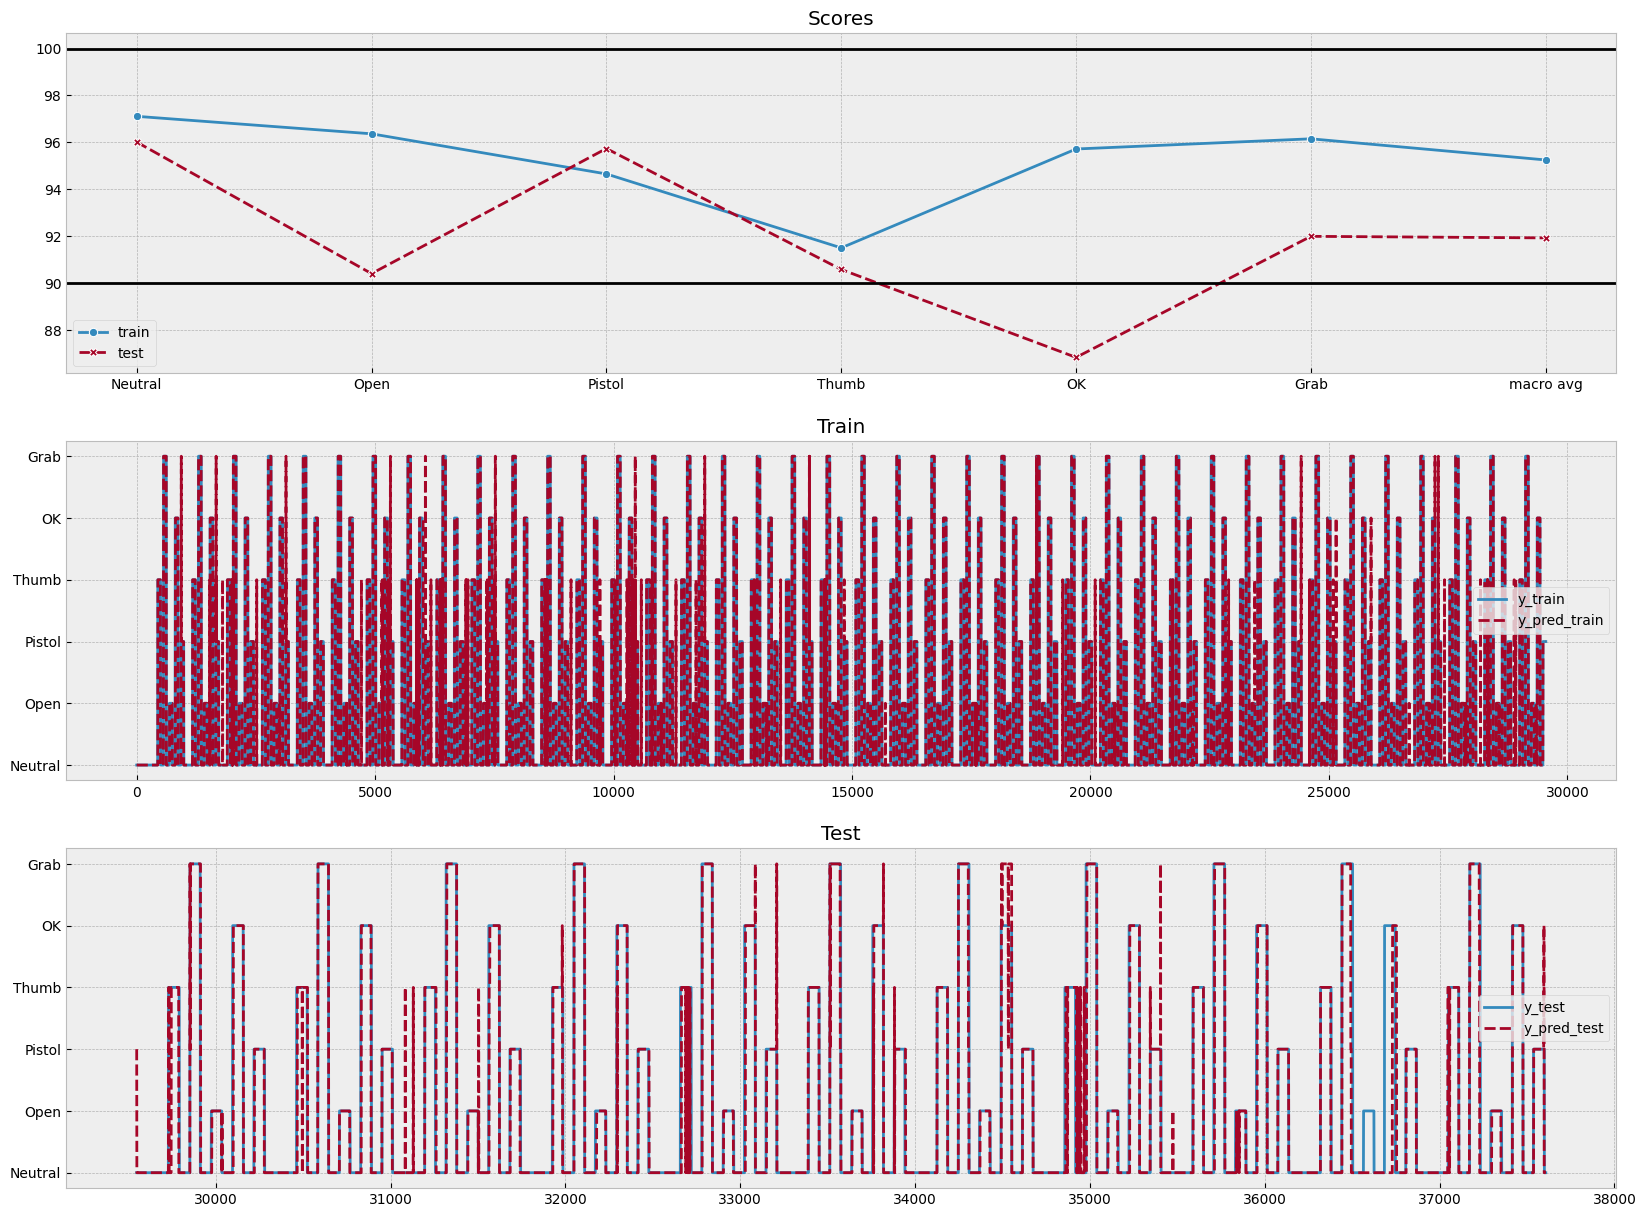

In [78]:
svm_model.set_params(**study_svm.best_params)

model_report(svm_model, Xy_set)

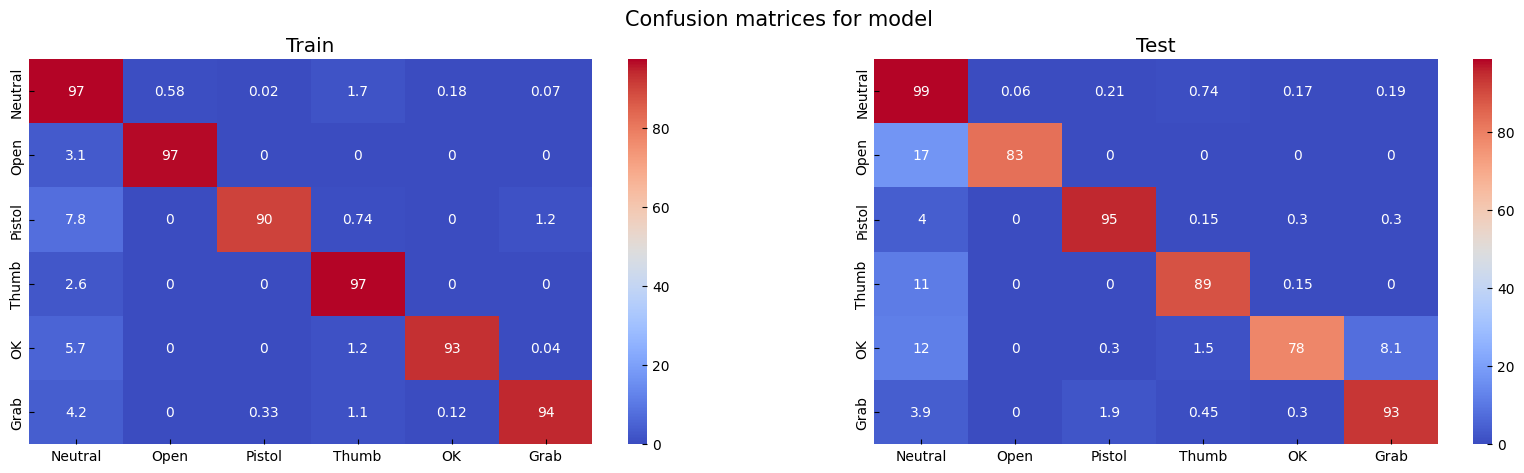

In [79]:
show_confusion_matrix(svm_model, Xy_set) 

-----

# Real-time inference

In [ ]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
]

    
def get_crc(data, count):
    result = 0x00
    l = count
    
    while count > 0:   
        result = crc_table[result ^ data[l-count]]
        count -= 1
        
    return result


def drv_abs_one(ser, control):
    if ser is None:
        return
    
    pack = np.array(([80, 0x01, 0xBB, 6] + 
                     [c for c in control] + 
                     [0]), 
                    dtype='uint8')
    pack[-1] = get_crc(pack[1:], 9)
    
    return pack, ser.write(bytearray(pack))

## Inference Utils: Put your code here

In [56]:
def preprocessing(x):
    # x - sample vector  
    X_sc = scaler.transform([x])
    X = pd.DataFrame(X_sc, columns=OMG_CH)[best_features]
    
    return X.values


def inference(x, model):
    y = model.predict(x)
    
    return y


def postprocessing(x, prev):
    x = x.reshape(1, -1)[0]
    
    if prev is None:
        y = x
    else:
        y = (x*0.1) + (prev*0.9) # Holt-Winters filter
        
    return y


def commands(x):
    y = np.round(np.clip(x/100, 0, 1) * 100).astype(int)
    return y

## Inference

### Offline (dataset)

In [55]:
palm_file = './data/2023-04-18_19-08-47 gestures train.palm'
gestures = read_omg_csv(palm_file, 
                        n_omg_channels=50,
                        n_acc_channels=3, 
                        n_gyr_channels=3, 
                        n_enc_channels=6, 
                        n_mag_channels=0)

y_cmd = read_protocol_csv(palm_file, gestures)

last_train_idx = train_test_split(palm_file, gestures, y_cmd, 0)[-2]
df_sim = gestures.iloc[last_train_idx:]

print(df_sim.shape)

(8076, 65)


In [86]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0

y_previous = None
y_dct = {
    'omg_sample': [],
    'enc_sample': [],
    'sample_preprocessed': [],
    'y_predicted': [],
    'y_postprocessed': [],
    'y_commands': [],
}


while True:    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < X_test.shape[0]:
            sample = df_sim.values[i]
        else:
            break
        
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
    
    # [Data preprocessing]
    y_dct['omg_sample'].append(omg_sample) 
    sample_preprocessed = preprocessing(omg_sample)[-10:]
    
    # [Inference]
    y_predicted = inference(sample_preprocessed, svm_model)
    
    # [Inference Postprocessing]
    y_postprocessed = postprocessing(y_predicted, y_previous)
    
    # [Commands composition]
    y_commands = commands(y_postprocessed)
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    
    # [Data logging]
         
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    
    assert ts_diff < TIMEOUT, 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 
    
    
for key, val in y_dct.items():
    y_dct[key] = np.stack(val)
    
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (8060, 50)
enc_sample.shape = (8060, 6)
sample_preprocessed.shape = (8060, 1, 34)
y_predicted.shape = (8060, 1)
y_postprocessed.shape = (8060, 1)
y_commands.shape = (8060, 1)


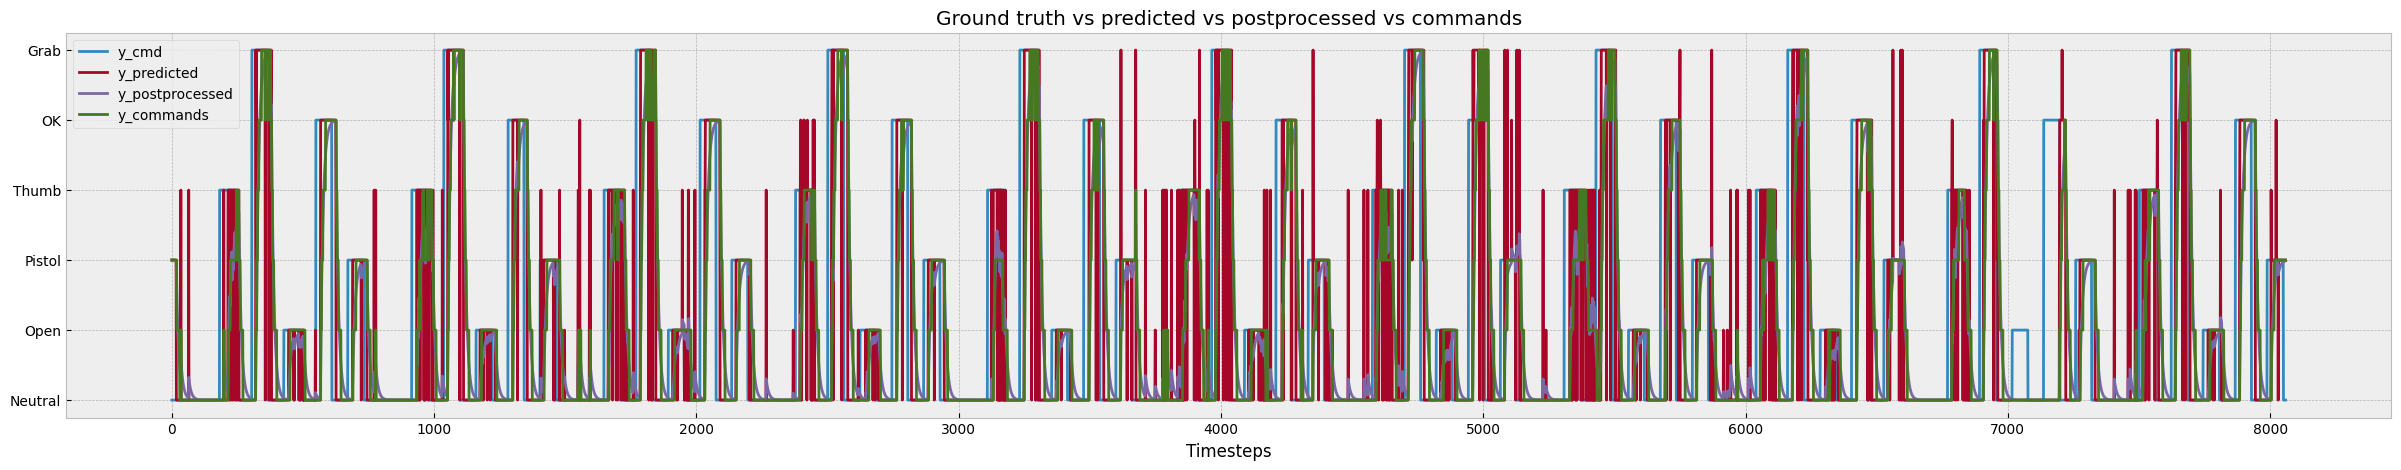

In [82]:
plt.figure(figsize=(30, 5))

plt.plot(y_test.values, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(range(NUM_G), GESTURES)
plt.legend()
plt.xlabel('Timesteps')

plt.show()

In [83]:
print(m.classification_report(y_test.values, 
                              y_dct['y_commands'], 
                              target_names=GESTURES)) 

              precision    recall  f1-score   support

     Neutral       0.73      0.65      0.69      4712
        Open       0.25      0.51      0.34       665
      Pistol       0.34      0.54      0.42       672
       Thumb       0.28      0.22      0.25       671
          OK       0.35      0.31      0.32       670
        Grab       0.59      0.27      0.37       670

    accuracy                           0.54      8060
   macro avg       0.42      0.42      0.40      8060
weighted avg       0.58      0.54      0.54      8060



### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
# ser_port = '/dev/ttyACM0'
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 